In [5]:
import re
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns

sys.path.insert(0, '../')

from src.plot import LogNorm
from src.utils import profile_binning
from src.GMM import GMM_bins, GMM 

%load_ext autoreload
%autoreload 2

In [6]:
drct = "../scripts/get_globular_clusters/output"

In [7]:
gc = pd.read_csv(os.path.join(drct, "NGC_104_47Tuc.csv"), skiprows=54, sep=" ")
gc["r"] = np.hypot(gc.x, gc.y)
gc["pm"] = np.hypot(gc.pmx, gc.pmy)
gc.head()

,x,y,pmx,pmy,pmx_e,pmy_e,pm_corr,g_mag,bp_rp,filter,memberprob,r,pm
0,-0.197768,-0.588896,4.437221,-3.046831,2.568937,2.304999,-0.435020,20.77880,0.816515,0,0.00000,0.621217,5.382575
1,-0.132277,-0.576262,-0.060467,-1.399454,1.140334,1.009628,-0.308144,20.19374,0.838819,0,0.00000,0.591248,1.400760
2,-0.130210,-0.584196,25.034540,2.431298,1.950605,1.598516,-0.185372,20.80205,2.071041,0,0.00000,0.598531,25.152324
3,-0.134829,-0.422390,4.965001,-1.958991,0.432121,0.295054,-0.275978,18.64288,0.965523,1,0.96083,0.443387,5.337498
4,-0.127499,-0.603662,0.654260,-0.609768,0.179726,0.137382,-0.125604,17.40447,1.302572,1,0.00000,0.616979,0.894357


In [8]:
gc.describe()

,x,y,pmx,pmy,pmx_e,pmy_e,pm_corr,g_mag,bp_rp,filter,memberprob,r,pm
count,126380.000000,126380.000000,126380.000000,126380.000000,126380.000000,126380.000000,126380.000000,126380.000000,107806.000000,126380.000000,126380.000000,126380.000000,126380.000000
mean,0.020448,-0.011716,4.551414,-2.277182,0.814111,0.675568,-0.111159,18.850155,0.935921,0.291953,0.189248,0.244169,5.624450
std,0.205895,0.208160,3.258890,2.235275,0.747640,0.661056,0.197171,1.388324,0.246328,0.454663,0.384176,0.163278,3.143767
min,-0.666213,-0.665482,-185.768100,-81.400120,0.023578,0.020528,-0.951285,10.600150,-1.243570,0.000000,0.000000,0.001046,0.014232
25%,-0.099703,-0.122219,3.726735,-2.915028,0.309020,0.250860,-0.225217,18.053233,0.801764,0.000000,0.000000,0.119399,4.726025
50%,0.011500,-0.006981,5.071260,-2.351073,0.573033,0.453512,-0.106138,19.053915,0.906712,0.000000,0.000000,0.191362,5.741681
75%,0.128428,0.105823,5.723011,-1.571697,1.048152,0.830895,-0.003526,19.852253,1.041331,1.000000,0.000000,0.331209,6.408186
max,0.666002,0.666213,107.301200,213.179700,5.227345,5.292846,0.982183,20.999300,4.339368,1.000000,0.998725,0.666647,282.763809


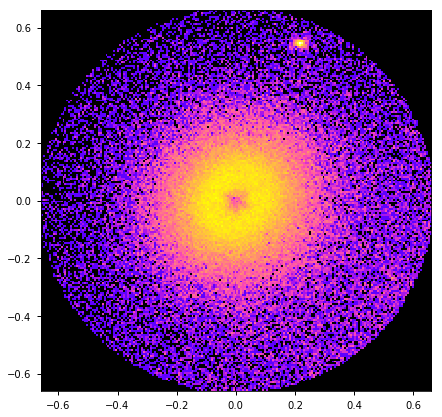

In [9]:
plt.figure(figsize=(7,7))
H, xb, yb, _ = plt.hist2d(gc.x, gc.y, bins=200, range=[[-0.66,0.66],[-0.66,0.66]], norm=LogNorm(), cmap="gnuplot2")

Text(0.5,0,'r')

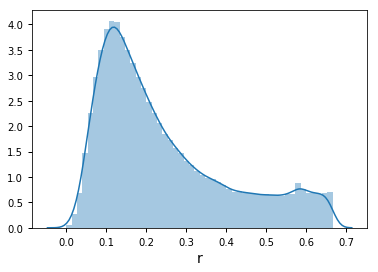

In [10]:
sns.distplot(gc.r)
plt.xlabel("r")

Pruning by scale radius and upper limit of proper motion

In [11]:
gcs = gc[(gc.r<18.3/60) & (gc.pm<15)]

Distribution of proper motion

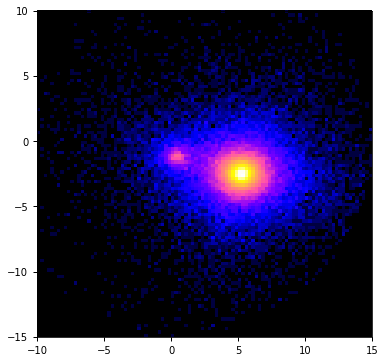

In [12]:
plt.figure(figsize=(6,6))
H, xb, yb, _ = plt.hist2d(gcs.pmx, gcs.pmy, bins=100, range=[[-10,15],[-15,10]], norm=LogNorm(), cmap="gnuplot2")

Text(0,0.5,'PM')

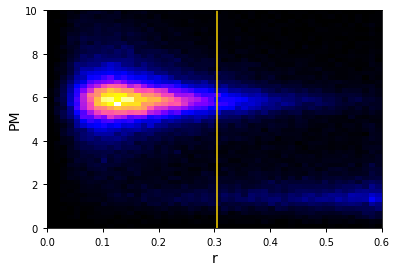

In [13]:
H, xb, yb, _ = plt.hist2d(gc.r, gc.pm, bins=50, range=[[0,0.6],[0,10]], cmap="gnuplot2")
# R scale
plt.axvline(18.3/60, color="gold")
plt.xlabel("r")
plt.ylabel("PM")

### Binning Start From Here

Bin the distribution of pm in radial bins.

In [14]:
gcs.pm

921       6.253721
922       6.003066
923       5.638154
924       1.751860
926       3.647526
            ...   
118857    6.847201
118861    6.315095
118866    5.671779
118895    6.027531
118899    4.900855
Name: pm, Length: 89986, dtype: float64

In [15]:
gcs.r

921       0.253596
922       0.221975
923       0.203092
924       0.274392
926       0.217474
            ...   
118857    0.235606
118861    0.265550
118866    0.275454
118895    0.289227
118899    0.273022
Name: r, Length: 89986, dtype: float64

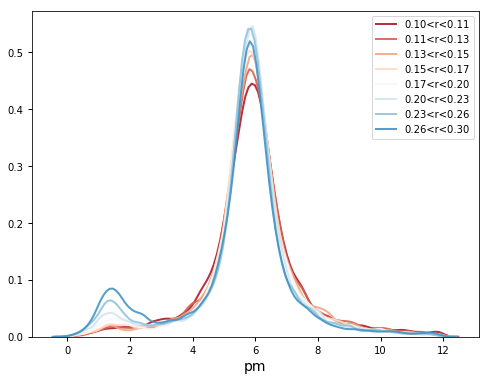

In [16]:
bins = np.logspace(np.log10(0.1), np.log10(0.3), 9)

sns.set_palette("RdBu", len(bins))
r_rbin, z_rbin, _ = profile_binning(gcs.r, gcs.pm, bins=bins, z_clip=[0,12],
                                 return_bin=False, plot=True)

Acquire all the stars from a particular bin:

In [17]:
_, _, z_bins = profile_binning(gcs.r, gcs.pm, bins=bins, z_clip=[0,12],
                         return_bin=True, plot=False)

PM radial profile

Text(0,0.5,'PM')

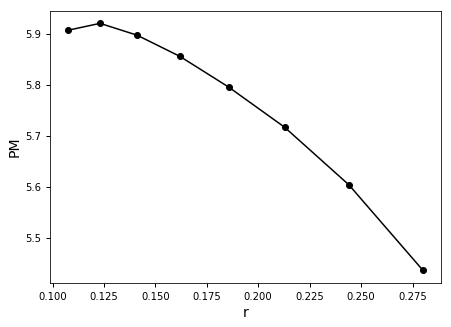

In [18]:
plt.figure(figsize=(7,5))
plt.plot(r_rbin, z_rbin, "k-o")
plt.xlabel("r")
plt.ylabel("PM")

### GMM start from here

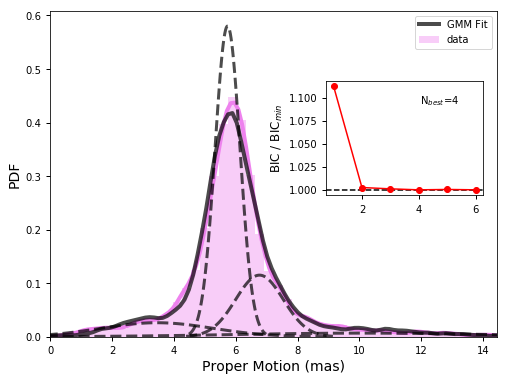

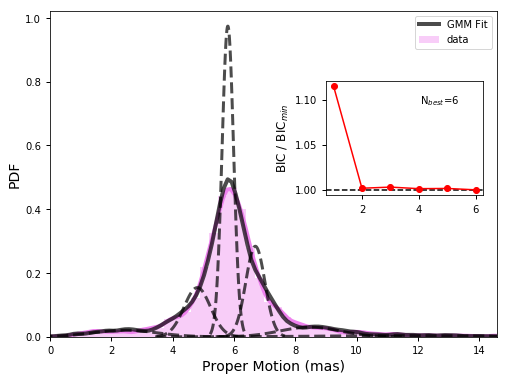

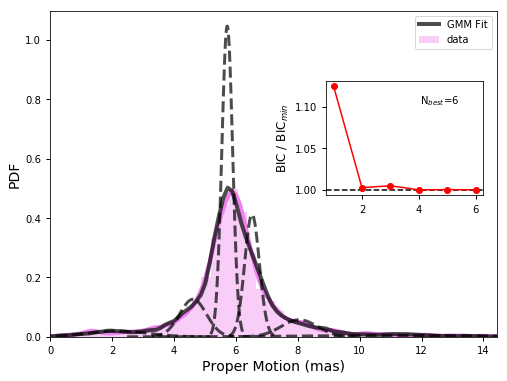

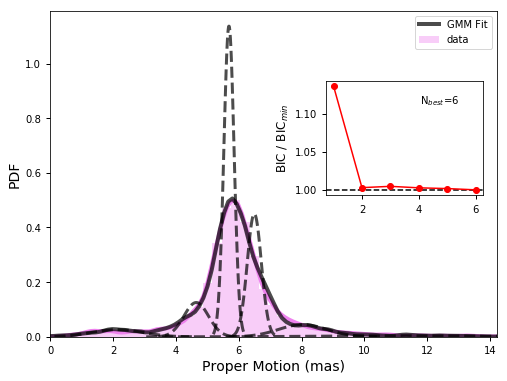

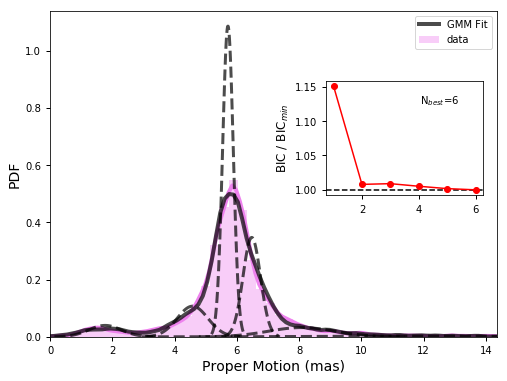

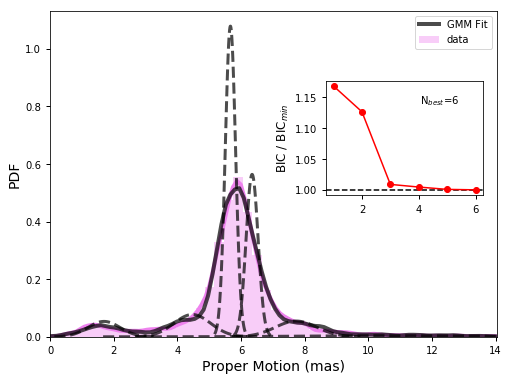

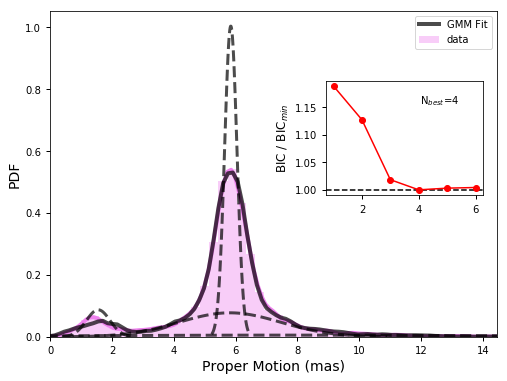

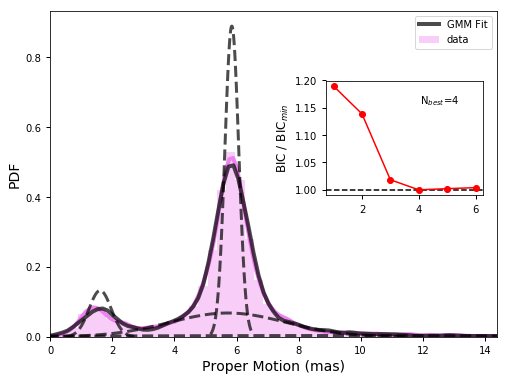

Finished


In [20]:
gmm_bins = GMM_bins(gcs, bins)
gmm_bins.run_GMM_bins(max_n_comp=6)

Probability that a star is giving by the major population. Passing a subsample

In [ ]:
data = z_bins["5"]["pm"]
prob_main_pop = gmma_bins.gmms[5].predict_main_pop(data)
prob_main_pop

Visualize GMM discrimination in each bin:

In [ ]:
gmm_bins.plot_pred_main_pop(p_thre=0.8)

In [ ]:
gmm_bins.plot_pred_main_pop_all(z_bins, p_thre=0.8)